**AIOps (Artificial Intelligence for IT Operations): Log clustering and analysis**

As described by Gartner, "AIOps combines big data and machine learning to automate IT operations processes, including event correlation, anomaly detection and causality determination."

The data for AIOps typically includes OpenTelemetry signals (Traces, Metrics, Logs) and other IT business data.

For this Capstone project, I'm currently focussing on using ML models to make it easier for Developers and Ops to analyze large volumes of logs.

Goals:
1. Millions of logs -> Clustered groups for easier analysis
   *   Simple Token based
   *   Advanced Semantics based
2. Outlier detection

Algorithms to evaluate (done):
* TF-IDF + Cosine similarity + DBSCAN

Algorithms to evaluate (planned/wip):
* TF-IDF + K-Means
* Sentence Embeddings + HDBSCAN
* TF-IDF + Isolation Forest
* TF-IDF + Naive Bayes

In [ ]:
import random, re
import math as math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

**Generate logs**

For ease of experimentation... simple code that can be adjusted to generate varying types of logs.
For now, starting small with < 100 logs to analyze. 

In [2]:
random.seed(42)

USERNAMES = ["user1", "user2", "user3", "user4"]
HOSTNAMES = ["host1", "host2", "host3", "host4"]
LOG_LEVELS = ["DEBUG", "INFO", "WARN", "ERROR", "CRITICAL", "SECURITY"]
THREADS = ["thread1", "thread2", "thread3", "thread4"]

ERRORS = [
    "ERROR User {id} failed login from {ip}",
    "ERROR Payment transaction {id} declined",
    "ERROR Database connection timeout after {num}ms"
]

INFOS = [
    "INFO User {id} logged in successfully",
    "INFO The User {id} logged in successfully",
    "INFO {id} logged in successfully",
    "INFO User: {id} logged in successfully",
    "INFO The User: {id} has logged in successfully now",
    "INFO Request completed with status 200 in {num}ms",
    "INFO Cache hit for key {id}"
]

DEBUGS = ["DEBUG Connection {id} checked out from Connection Pool",
          "DEBUG Connection {id} checked in to Connection Pool",
          "DEBUG Retrieved remote configuration successfully",
          "DEBUG Found no local over-riding configuration, applied remote configuration successfully"]

WARNS = [
    "WARN Disk usage at {num}%",
    "WARN Retry attempt {num} for service auth"
]

ANOMALIES_CRITICAL = [
    "CRITICAL Kernel panic at memory address {id}"
]
ANOMALIES_SECURITY = [
    "SECURITY Possible data exfiltration detected from {ip}"
]

def rand_ip():
    return ".".join(str(random.randint(1, 255)) for _ in range(4))

all_log_entries = []

# Define desired log counts based on 70 total logs
TOTAL_LOG_COUNT = 70
log_distribution_percentages = {
    "DEBUG": 0.70,
    "INFO": 0.15,
    "WARN": 0.05,
    "ERROR": 0.07,
    "CRITICAL": 0.02,
    "SECURITY": 0.01
}

log_counts = {}
current_sum = 0
for level, percentage in log_distribution_percentages.items():
    count = round(TOTAL_LOG_COUNT * percentage)
    log_counts[level] = count
    current_sum += count

# Adjust for rounding errors to ensure total sum is accurate
difference = TOTAL_LOG_COUNT - current_sum
if difference != 0:
    # Find the level with the largest count to adjust (can be positive or negative adjustment)
    max_level = max(log_counts, key=log_counts.get)
    log_counts[max_level] += difference

# Parameterize time range
TIME_RANGE_VALUE = 60 # e.g., 60 for 60 minutes/hours/days
TIME_RANGE_UNIT = "minutes" # Options: "minutes", "hours", "days"

end_time = datetime.datetime.now()
if TIME_RANGE_UNIT == "minutes":
    start_time = end_time - datetime.timedelta(minutes=TIME_RANGE_VALUE)
elif TIME_RANGE_UNIT == "hours":
    start_time = end_time - datetime.timedelta(hours=TIME_RANGE_VALUE)
elif TIME_RANGE_UNIT == "days":
    start_time = end_time - datetime.timedelta(days=TIME_RANGE_VALUE)
else:
    raise ValueError("Invalid TIME_RANGE_UNIT. Must be 'minutes', 'hours', or 'days'.")

# Generate logs based on the specified distribution
for log_level, count in log_counts.items():
    for _ in range(count):
        # Generate a random timestamp within the defined range
        time_delta_seconds = (end_time - start_time).total_seconds()
        random_second_offset = random.uniform(0, time_delta_seconds)
        random_datetime = start_time + datetime.timedelta(seconds=random_second_offset)
        current_time = random_datetime.strftime("%Y-%m-%d %H:%M:%S")

        username = random.choice(USERNAMES)
        hostname = random.choice(HOSTNAMES)
        thread = random.choice(THREADS)

        raw_log = ""
        template = None

        if log_level == "DEBUG":
            template = random.choice(DEBUGS)
            raw_log = template.format(id=random.randint(1000, 9999))
        elif log_level == "INFO":
            template = random.choice(INFOS)
            raw_log = template.format(id=random.randint(1000, 9999), num=random.randint(1, 5000))
        elif log_level == "WARN":
            template = random.choice(WARNS)
            raw_log = template.format(num=random.randint(1, 100))
        elif log_level == "ERROR":
            template = random.choice(ERRORS)
            raw_log = template.format(id=random.randint(1000, 9999), ip=rand_ip(), num=random.randint(1, 5000))
        elif log_level == "CRITICAL":
            template = random.choice(ANOMALIES_CRITICAL)
            raw_log = template.format(id=random.randint(10000, 99999))
        elif log_level == "SECURITY":
            template = random.choice(ANOMALIES_SECURITY)
            raw_log = template.format(ip=rand_ip())

        all_log_entries.append({
            "Timestamp": current_time,
            "Username": username,
            "Hostname": hostname,
            "Thread": thread,
            "Log_Level": log_level,
            "raw_log": raw_log
        })

df = pd.DataFrame(all_log_entries)
df.head()

,Timestamp,Username,Hostname,Thread,Log_Level,raw_log
0,2026-02-17 19:48:32,user1,host3,thread2,DEBUG,DEBUG Connection 3286 checked in to Connection...
1,2026-02-17 19:54:22,user1,host4,thread1,DEBUG,DEBUG Connection 2535 checked out from Connect...
2,2026-02-17 19:23:17,user1,host2,thread4,DEBUG,DEBUG Connection 8359 checked in to Connection...
3,2026-02-17 19:45:32,user1,host2,thread4,DEBUG,DEBUG Retrieved remote configuration successfully
4,2026-02-17 19:19:30,user3,host1,thread1,DEBUG,DEBUG Found no local over-riding configuration...


**Visualize logs**
View the spread of logs by log level, username, hostname.

In [3]:
log_level_counts = df['Log_Level'].value_counts()
username_counts = df['Username'].value_counts()
hostname_counts = df['Hostname'].value_counts()

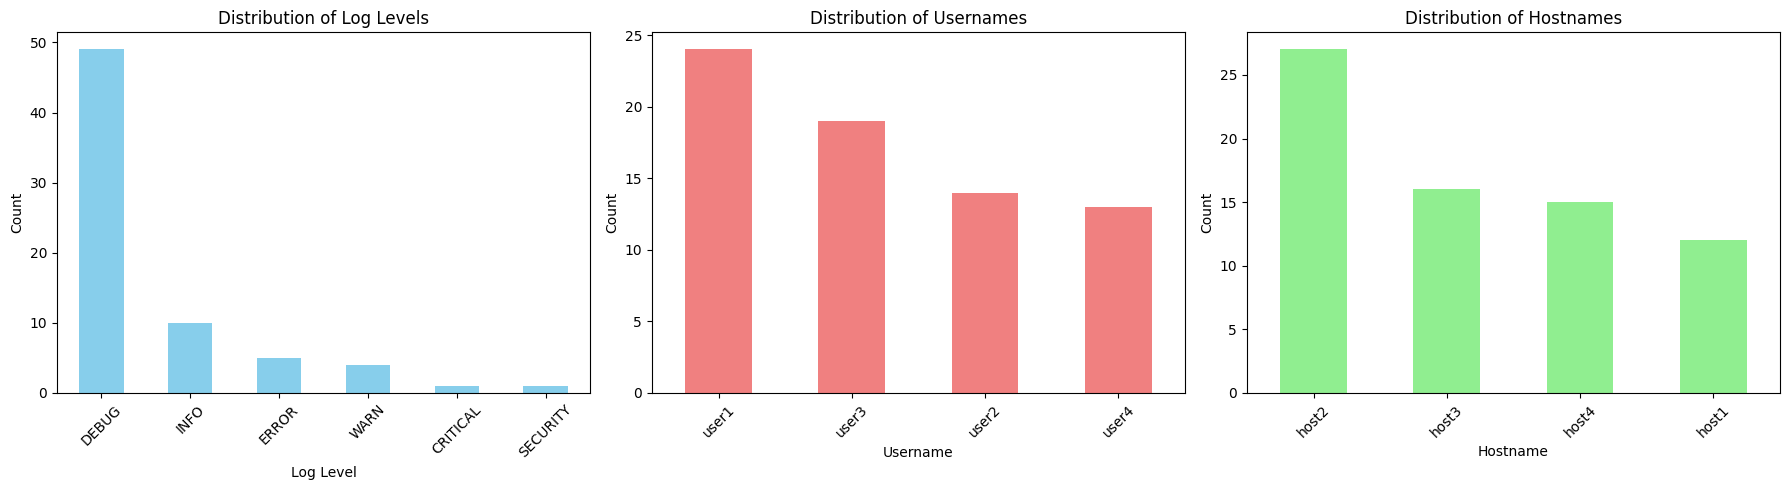

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

log_level_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Log Levels')
axes[0].set_xlabel('Log Level')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

username_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution of Usernames')
axes[1].set_xlabel('Username')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

hostname_counts.plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Distribution of Hostnames')
axes[2].set_xlabel('Hostname')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Pre-processing for analysis**
1. Normalize logs by removing numeric values, IP addresses, etc.
2. Remove stop words
3. Tokenize and sort log entries

In [6]:
def normalize(log):
    log = log.lower()
    log = re.sub(r"(\d+\.\d+\.\d+\.\d+)", "<IP>", log)
    log = re.sub(r"\b\d+", "<NUM>", log)
    return log

df["norm_log"] = df["raw_log"].apply(normalize)

def remove_stopwords(text):
    words = text.split()  # Simple tokenization by splitting on spaces
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return " ".join(filtered_words)

df["no_stop_log"] = df["norm_log"].apply(remove_stopwords)

df["tokenized_sorted_log"] = df["no_stop_log"].apply(lambda x: ' '.join(sorted(x.split())))
df.head()

,Timestamp,Username,Hostname,Thread,Log_Level,raw_log,norm_log,no_stop_log,tokenized_sorted_log
0,2026-02-17 19:48:32,user1,host3,thread2,DEBUG,DEBUG Connection 3286 checked in to Connection...,debug connection <NUM> checked in to connectio...,debug connection <NUM> checked connection pool,<NUM> checked connection connection debug pool
1,2026-02-17 19:54:22,user1,host4,thread1,DEBUG,DEBUG Connection 2535 checked out from Connect...,debug connection <NUM> checked out from connec...,debug connection <NUM> checked connection pool,<NUM> checked connection connection debug pool
2,2026-02-17 19:23:17,user1,host2,thread4,DEBUG,DEBUG Connection 8359 checked in to Connection...,debug connection <NUM> checked in to connectio...,debug connection <NUM> checked connection pool,<NUM> checked connection connection debug pool
3,2026-02-17 19:45:32,user1,host2,thread4,DEBUG,DEBUG Retrieved remote configuration successfully,debug retrieved remote configuration successfully,debug retrieved remote configuration successfully,configuration debug remote retrieved successfully
4,2026-02-17 19:19:30,user3,host1,thread1,DEBUG,DEBUG Found no local over-riding configuration...,debug found no local over-riding configuration...,"debug local over-riding configuration, applied...","applied configuration configuration, debug loc..."


**Visualize the results of pre-processing**

Shows progressrive results, shrinking from 70 total logs, to 15 distinct log patterns. 

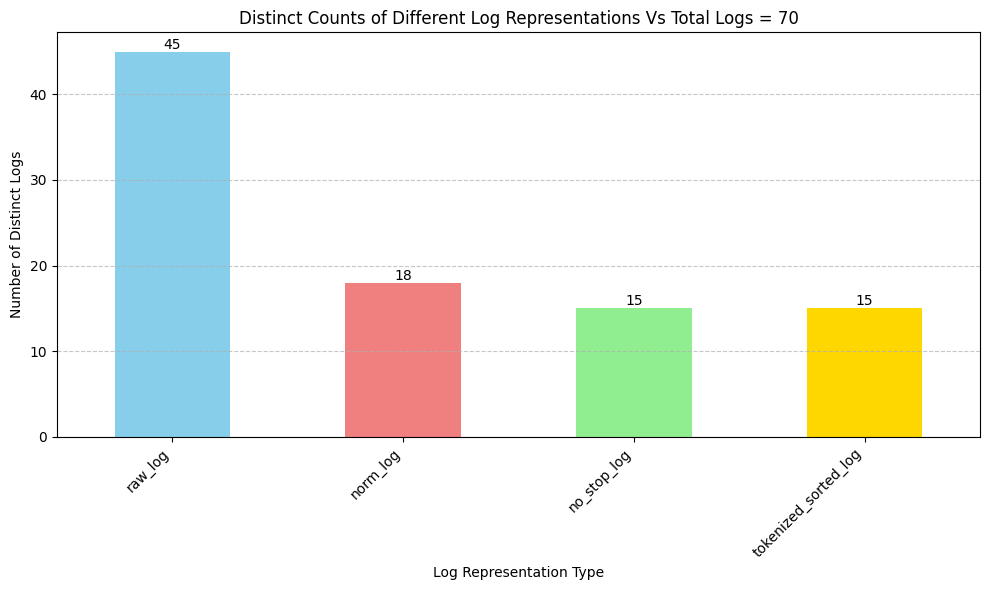

In [36]:
# Calculate distinct counts for each log type
distinct_counts = {
    'raw_log': df['raw_log'].nunique(),
    'norm_log': df['norm_log'].nunique(),
    'no_stop_log': df['no_stop_log'].nunique(),
    'tokenized_sorted_log': df['tokenized_sorted_log'].nunique()
}

# Convert to a pandas Series for easy plotting
distinct_counts_series = pd.Series(distinct_counts)

# Create the bar chart
plt.figure(figsize=(10, 6))
distinct_counts_series.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title(f'Distinct Counts of Different Log Representations Vs Total Logs = {df.shape[0]}')
plt.xlabel('Log Representation Type')
plt.ylabel('Number of Distinct Logs')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Add count labels on top of each bar
for i, v in enumerate(distinct_counts_series):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

**Vectorize the logs**

Transform logs into a numerical matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features.

In [18]:
print("Number of tokenized_sorted_log entries:", len(df))
df_distinct = df.drop_duplicates(subset="tokenized_sorted_log")
tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_distinct['no_stop_log'])
tfidf_matrix = tfidf_vectorizer.fit_transform(df_distinct['tokenized_sorted_log'])
tfidf_dense_matrix = tfidf_matrix.toarray()

print("Shape of TF-IDF matrix:", tfidf_dense_matrix.shape)
print("First 5 rows of TF-IDF dense matrix:\n", tfidf_dense_matrix[:5])

Number of tokenized_sorted_log entries: 70
Shape of TF-IDF matrix: (15, 49)
First 5 rows of TF-IDF dense matrix:
 [[0.         0.         0.         0.         0.         0.41629543
  0.         0.         0.72296496 0.         0.         0.
  0.32259207 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.16325517
  0.         0.         0.         0.41629543 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.46267453 0.         0.         0.         0.
  0.41289729 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.46267453
  0.    

**Cosine similarity**

Measure the similarity between each of the distinct log patterns by calculating the cosine of the angle between them

In [28]:
# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_dense_matrix)
# cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Convert similarity matrix to distance matrix
cosine_dist_matrix = 1 - cosine_sim_matrix

print("Shape of Cosine Similarity Matrix:", cosine_sim_matrix.shape)
print("First 5x5 block of Cosine Similarity Matrix:\n", cosine_sim_matrix[:5, :5])
print("\nShape of Cosine Distance Matrix:", cosine_dist_matrix.shape)
print("First 5x5 block of Cosine Distance Matrix:\n", cosine_dist_matrix[:5, :5])

Shape of Cosine Similarity Matrix: (15, 15)
First 5x5 block of Cosine Similarity Matrix:
 [[1.         0.13319739 0.08434385 0.04333872 0.04333872]
 [0.13319739 1.         0.58899897 0.14923956 0.14923956]
 [0.08434385 0.58899897 1.         0.09450215 0.09450215]
 [0.04333872 0.14923956 0.09450215 1.         1.        ]
 [0.04333872 0.14923956 0.09450215 1.         1.        ]]

Shape of Cosine Distance Matrix: (15, 15)
First 5x5 block of Cosine Distance Matrix:
 [[ 0.00000000e+00  8.66802606e-01  9.15656145e-01  9.56661281e-01
   9.56661281e-01]
 [ 8.66802606e-01 -2.22044605e-16  4.11001031e-01  8.50760438e-01
   8.50760438e-01]
 [ 9.15656145e-01  4.11001031e-01  2.22044605e-16  9.05497851e-01
   9.05497851e-01]
 [ 9.56661281e-01  8.50760438e-01  9.05497851e-01 -2.22044605e-16
  -2.22044605e-16]
 [ 9.56661281e-01  8.50760438e-01  9.05497851e-01 -2.22044605e-16
  -2.22044605e-16]]


**DBSCAN**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a non-parametric, density-based clustering algorithm that identifies clusters of arbitrary shape in large, noisy datasets. It groups closely packed points based on two parameters—eps (neighborhood radius) and minPts (minimum points to form a dense region)—and marks low-density points as outliers.

In [32]:
# Apply DBSCAN clustering
# dbscan = DBSCAN(eps=2, min_samples=1, metric='precomputed')
dbscan = DBSCAN(eps=0.3, min_samples=1, metric='euclidean', algorithm='auto')
# df_distinct['cluster_label'] = dbscan.fit_predict(hamming_matrix)
df_distinct['cluster_label'] = dbscan.fit_predict(cosine_sim_matrix)
# df_distinct['cluster_label'] = dbscan.fit_predict(tfidf_dense_matrix)

print("DBSCAN Clustering Results:")
print(df_distinct[['tokenized_sorted_log', 'cluster_label']])

DBSCAN Clustering Results:
                                 tokenized_sorted_log  cluster_label
0      <NUM> checked connection connection debug pool              0
3   configuration debug remote retrieved successfully              1
4   applied configuration configuration, debug loc...              2
49                <NUM> info logged successfully user              3
50               <NUM> info logged successfully user:              3
51                           <NUM> cache hit info key              4
52                     <NUM> info logged successfully              5
57        <NUM> <NUM>ms completed info request status              6
59              <NUM> attempt auth retry service warn              7
62                             <NUM>% disk usage warn              8
63          <NUM>ms connection database error timeout              9
64           <NUM> declined error payment transaction             10
65                 <IP> <NUM> error failed login user             11
68     

C:\Users\kunal\AppData\Local\Temp\ipykernel_27664\1070381342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distinct['cluster_label'] = dbscan.fit_predict(cosine_sim_matrix)


**Summary and next steps**

For this initial experiment, I started with 70 raw logs, and after applying some rudimentary text replacement/cleanup, quickly narrowed down to 15 unique (tokenized_sorted_log) patterns.
For the baseline, applying TfidfVectorizer and Cosine similarity, with DBSCAN yielded 14 log clusters.

For next steps, I will apply other ML models to try to further reduce the number of clusters, identify outliers, and visualize the data better. Also, gradually grow the volume of logs to better analyze each model's performance.

Algorithms to evaluate (planned/wip):
* TF-IDF + K-Means
* Sentence Embeddings + HDBSCAN
* TF-IDF + Isolation Forest
* TF-IDF + Naive Bayes